## Import the necessary libraries

In [1]:
# To run the volatility strategies as well as to observe their performance
from trading_volatility import TradingVolatility
from perf_measure import PerformanceMetrics
import pandas as pd

# For visualisation
import seaborn as sns
sns.set_style("darkgrid")

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

## Strategy 1: Long Short VIX (LSV)

### 1.1 Data loading and preprocessing

In [2]:
# Tickers to be used in the lsv strategy
lsv_tickers = ['VIXY', 'SVXY']
lsv_indices = ['^VIX']

In [3]:
lsv_trader = TradingVolatility(volatility_assets=lsv_tickers,
                               volatility_indices=lsv_indices)

# Historical data for 1-month VIX futures cannot be retreived using Yahoo Finanace API, hence manual upload
lsv_trader.get_data(start_date="2011-10-11",
                    end_date="2020-04-01",
                    col_rename='vx_open',
                    manual_loading="S&P 500 VIX Futures Historical Data.csv")

2025-06-22 14:06:46,930 - INFO - File loaded successfully.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open
Date,,,,,,
2011-10-11,809440.000000,790160.000000,12.0625,12.3150,33.950001,34.67
2011-10-12,761280.000000,736800.000000,12.7900,13.1725,31.570000,34.47
2011-10-13,745600.000000,735360.000000,13.0000,13.0675,31.990000,32.80
2011-10-14,703440.000000,692560.000000,13.8475,13.9375,29.070000,31.13
2011-10-17,696000.000000,765760.000000,13.7250,12.4050,30.350000,29.42
...,...,...,...,...,...,...
2020-03-25,3160.000000,3328.000000,15.4800,15.0650,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.2250,15.6750,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.8600,14.9250,64.949997,46.35


> Note: 1-to-4 reverse stock split for VIXY announced on 1/11/2024, hence price changes from previous version of notebook. 

In [4]:
# Check if the data was loaded
lsv_trader.data.tail()

,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open
Date,,,,,,
2020-03-25,3160.000000,3328.000000,15.480,15.065,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.225,15.675,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.860,14.925,64.949997,46.35
2020-03-30,3312.800049,3199.199951,14.900,15.125,66.300003,55.45
2020-03-31,3211.199951,3034.399902,15.085,15.505,56.689999,49.60


### 1.2 Signals Generation

If basis is negative then term structure is backwardation. If basis is positive, then term structure is contango.

Formula for basis:
$$B_{t}=\frac{VIX_{1}}{VIX_{spot}}-1$$

>Note: This calculation is included in the `._lsv_signals` method, but if you want to you can use `._TradingVolatility__daily_basis` method to view the basis for each trading day after you've run the `._lsv_signals` method.

Next, we want to generate the buy/sell signals for our LSV strategy. For each trading day:

1. We first check the basis
2. If negative, then vix futures term sturcture in backwardation (i.e. shorter term maturites are priced higher than longer-dated maturities - demand for S&P options might have surged due to higer risk and uncertainty in the markt which in turn affects VIX index and VIX futures given their inverse relationship with the S&P)
3. If in backwardation, we want exposure to asset that longs the VIX futures (i.e. `VIXY`) as well as removing short exposure to VIX futures (i.e. `SVXY`)
4. Consequently, there can be 3 scenarios that can occur at market open on each trading day:

    i. If there is no open long position in either VIXY or SVXY, then we generate a `buy_signal` for VIXY at its market open price

    ii. If there is an open position in SVXY but no open position in VIXY, then we create a `sell_signal` as well as a `buy_signal` for VIXY, both at the market open price
    
    iii. Lastly, if there is already an open position in VIXY, then we don't have to generate any signal for the day

In [5]:
# Method signature as such to help us identify the individual index tickers for basis calculation
lsv_trader._TradingVolatility__lsv_signals(long_vix_asset="VIXY",
                                           short_vix_asset="SVXY",
                                           future_index_ticker="VX",
                                           spot_index_ticker="^VIX")

,vixy_sell_signal,svxy_sell_signal,vixy_buy_signal,svxy_buy_signal
Date,,,,
2011-10-11,NaN,NaN,NaN,12.0625
2011-10-12,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN
2011-10-17,NaN,13.725,696000.0,NaN
...,...,...,...,...
2020-03-25,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN


In [6]:
# Check to see if the basis column was added  to `data` after generating our signals
lsv_trader.data.head()

,vixy_open,vixy_close,svxy_open,svxy_close,^vix_open,vx_open,basis
Date,,,,,,,
2011-10-11,809440.0,790160.0,12.0625,12.3150,33.950001,34.67,0.021208
2011-10-12,761280.0,736800.0,12.7900,13.1725,31.570000,34.47,0.091859
2011-10-13,745600.0,735360.0,13.0000,13.0675,31.990000,32.80,0.025320
2011-10-14,703440.0,692560.0,13.8475,13.9375,29.070000,31.13,0.070863
2011-10-17,696000.0,765760.0,13.7250,12.4050,30.350000,29.42,-0.030643


### 1.3 Trade Execution

In [7]:
lsv_returns = lsv_trader.lsv_strategy(intial_capital=100000,
                                      long_vix_asset="VIXY",
                                      short_vix_asset="SVXY",
                                      future_index_ticker="VX",
                                      spot_index_ticker="^VIX")

lsv_returns.tail()

,asset_history,holding_quantity,available_cash,asset_close_price,asset_value,portfolio_value,portfolio_returns,portfolio_cumulative_returns
Date,,,,,,,,
2020-03-25,vixy,9183.64,27.751843,3328.000000,3.056315e+07,3.056318e+07,0.081081,298.365324
2020-03-26,vixy,9183.64,27.751843,3036.000000,2.788153e+07,2.788156e+07,-0.087740,272.098919
2020-03-27,vixy,9183.64,27.751843,3304.800049,3.035009e+07,3.035012e+07,0.088537,296.278409
2020-03-30,vixy,9183.64,27.751843,3199.199951,2.938030e+07,2.938033e+07,-0.031954,286.779316
2020-03-31,vixy,9183.64,27.751843,3034.399902,2.786684e+07,2.786686e+07,-0.051513,271.954985


### 1.4 Performance Evaluation

In [8]:
lsv_perf = PerformanceMetrics()
lsv_perf.average_annual_geometric_return(portfolio_value=lsv_returns['portfolio_value'])

np.float64(0.5631809095002366)

In [9]:
lsv_perf.annualised_downside_vol(portfolio_return=lsv_returns['portfolio_returns'])

np.float64(0.4003865957283223)

In [10]:
lsv_perf.annualised_vol(portfolio_return=lsv_returns['portfolio_returns'])

np.float64(0.6386624426685285)

<Axes: xlabel='Date'>

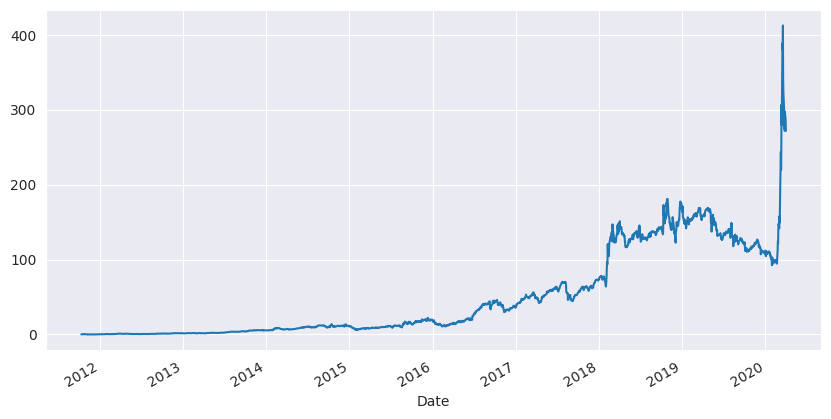

In [11]:
lsv_returns["portfolio_cumulative_returns"].plot(figsize=(10,5))

## Strategy 2: Hedged Long Short VIX (HLSV) 

### 2.1 Data loading and preprocessing

In [12]:
# Tickers to be used in the hlsv strategy
hlsv_tickers = ['VIXY', 'SVXY', 'SPY']
hlsv_indices = ['^VIX']

In [13]:
hlsv_trader = TradingVolatility(volatility_assets=hlsv_tickers,
                                volatility_indices=hlsv_indices)

# Historical data for 1-month VIX futures cannot be retreived using Yahoo Finanace API, hence manual upload
hlsv_trader.get_data(start_date="2011-10-11",
                     end_date="2020-04-01",
                     col_rename='vx_open',
                     manual_loading="S&P 500 VIX Futures Historical Data.csv")

2025-06-22 14:06:48,275 - INFO - File loaded successfully.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close,^vix_open,vx_open
Date,,,,,,,,
2011-10-11,809440.000000,790160.000000,12.0625,12.3150,92.787040,93.434914,33.950001,34.67
2011-10-12,761280.000000,736800.000000,12.7900,13.1725,94.137429,94.254517,31.570000,34.47
2011-10-13,745600.000000,735360.000000,13.0000,13.0675,93.700282,94.067154,31.990000,32.80
2011-10-14,703440.000000,692560.000000,13.8475,13.9375,95.159964,95.675140,29.070000,31.13
2011-10-17,696000.000000,765760.000000,13.7250,12.4050,95.222434,93.848625,30.350000,29.42
...,...,...,...,...,...,...,...,...
2020-03-25,3160.000000,3328.000000,15.4800,15.0650,227.003947,228.783859,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.2250,15.6750,231.314698,242.142517,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.8600,14.9250,234.791095,234.930145,64.949997,46.35


In [14]:
# Check if the data was loaded
hlsv_trader.data.tail()

,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close,^vix_open,vx_open
Date,,,,,,,,
2020-03-25,3160.000000,3328.000000,15.480,15.065,227.003947,228.783859,61.439999,47.00
2020-03-26,3222.399902,3036.000000,15.225,15.675,231.314698,242.142517,65.669998,51.50
2020-03-27,3301.600098,3304.800049,14.860,14.925,234.791095,234.930145,64.949997,46.35
2020-03-30,3312.800049,3199.199951,14.900,15.125,237.043800,242.559677,66.300003,55.45
2020-03-31,3211.199951,3034.399902,15.085,15.505,241.549190,238.944214,56.689999,49.60


### 2.2 Signals Generation

In [15]:
hlsv_trader._TradingVolatility__hlsv_signals(long_vix_asset="VIXY",
                                             short_vix_asset="SVXY",
                                             hedge_asset="SPY", 
                                             future_index_ticker="VX", 
                                             spot_index_ticker="^VIX")

,vixy_sell_signal,svxy_sell_signal,long_spy_sell_signal,short_spy_sell_signal,vixy_buy_signal,svxy_buy_signal,long_spy_buy_signal,short_spy_buy_signal
Date,,,,,,,,
2011-10-11,NaN,NaN,NaN,NaN,NaN,12.0625,NaN,92.78704
2011-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-17,NaN,13.725,NaN,95.222434,696000.0,NaN,95.222434,NaN
...,...,...,...,...,...,...,...,...
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Trade Execution

In [16]:
hlsv_returns = hlsv_trader.hlsv_strategy(intial_capital=100000,
                                        long_vix_asset="VIXY",
                                        short_vix_asset="SVXY",
                                        hedge_asset="SPY",
                                        future_index_ticker="VX",
                                        spot_index_ticker="^VIX")

hlsv_returns.head()

,asset_history,asset_quantity,hedge_history,hedge_quantity,available_cash,asset_value,hedge_value,portfolio_value,portfolio_returns,portfolio_cumulative_returns
Date,,,,,,,,,,
2011-10-11,svxy,4145.07,short_spy,-538.87,100000.245530,51046.535311,-50349.271911,100697.508930,NaN,NaN
2011-10-12,svxy,4145.07,short_spy,-538.87,100000.245530,54600.933152,-50790.931361,103810.247321,0.030912,0.030912
2011-10-13,svxy,4145.07,short_spy,-538.87,100000.245530,54165.702699,-50689.967239,103475.980991,-0.003220,0.027592
2011-10-14,svxy,4145.07,short_spy,-538.87,100000.245530,57771.913125,-51556.462897,106215.695758,0.026477,0.054800
2011-10-17,vixy,0.07,long_spy,554.37,4070.358878,53603.200000,52026.862343,109700.421220,0.032808,0.089406


### 2.4 Performance Evaluation

In [17]:
hlsv_perf = PerformanceMetrics()
hlsv_perf.average_annual_geometric_return(hlsv_returns['portfolio_value'])

np.float64(0.3206311394390498)

In [18]:
hlsv_perf.annualised_downside_vol(hlsv_returns['portfolio_returns'])

np.float64(0.18199324081034926)

In [19]:
hlsv_perf.annualised_vol(portfolio_return=hlsv_returns['portfolio_returns'])

np.float64(0.30583640441892207)

<Axes: xlabel='Date'>

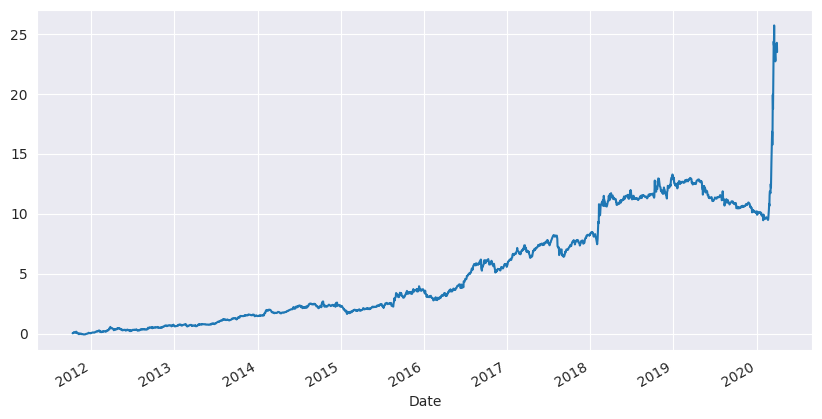

In [20]:
hlsv_returns["portfolio_cumulative_returns"].plot(figsize=(10,5))

## Strategy 3: Long SPY and Long VIX Strategy (LSLV)

### 3.1 Data loading and preprocessing

In [21]:
# Tickers to be used in the lslv strategy
lslv_tickers = ['VIXY', 'SPY']
lslv_indices = ['^VIX']

In [22]:
lslv_trader = TradingVolatility(volatility_assets=lslv_tickers,
                                volatility_indices=lslv_indices)

# Historical data for 1-month VIX futures cannot be retreived using Yahoo Finanace API, hence manual upload
lslv_trader.get_data(start_date="2011-10-11",
                     end_date="2020-04-01",
                     col_rename='vx_open',
                     manual_loading="S&P 500 VIX Futures Historical Data.csv")

2025-06-22 14:06:49,739 - INFO - File loaded successfully.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


,vixy_open,vixy_close,spy_open,spy_close,^vix_open,vx_open
Date,,,,,,
2011-10-11,809440.000000,790160.000000,92.787040,93.434914,33.950001,34.67
2011-10-12,761280.000000,736800.000000,94.137429,94.254517,31.570000,34.47
2011-10-13,745600.000000,735360.000000,93.700282,94.067154,31.990000,32.80
2011-10-14,703440.000000,692560.000000,95.159964,95.675140,29.070000,31.13
2011-10-17,696000.000000,765760.000000,95.222434,93.848625,30.350000,29.42
...,...,...,...,...,...,...
2020-03-25,3160.000000,3328.000000,227.003947,228.783859,61.439999,47.00
2020-03-26,3222.399902,3036.000000,231.314698,242.142517,65.669998,51.50
2020-03-27,3301.600098,3304.800049,234.791095,234.930145,64.949997,46.35


In [23]:
# Check if the data was loaded
lslv_trader.data.tail()

,vixy_open,vixy_close,spy_open,spy_close,^vix_open,vx_open
Date,,,,,,
2020-03-25,3160.000000,3328.000000,227.003947,228.783859,61.439999,47.00
2020-03-26,3222.399902,3036.000000,231.314698,242.142517,65.669998,51.50
2020-03-27,3301.600098,3304.800049,234.791095,234.930145,64.949997,46.35
2020-03-30,3312.800049,3199.199951,237.043800,242.559677,66.300003,55.45
2020-03-31,3211.199951,3034.399902,241.549190,238.944214,56.689999,49.60


### 3.2 Signals Generation

In [24]:
lslv_trader._TradingVolatility__lslv_signals(long_vix_asset="VIXY",
                                             long_hedge_asset="SPY",
                                             future_index_ticker="VX",
                                             spot_index_ticker="^VIX").head(20)

,vixy_25_sell_signal,spy_75_sell_signal,vixy_25_buy_signal,spy_100_buy_signal
Date,,,,
2011-10-11,809440.0,NaN,NaN,92.787040
2011-10-12,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN
2011-10-17,NaN,95.222434,696000.0,NaN
2011-10-18,NaN,NaN,NaN,NaN
2011-10-19,NaN,NaN,NaN,NaN
2011-10-20,NaN,NaN,NaN,NaN
2011-10-21,763680.0,NaN,NaN,96.081057


### 3.3 Trade Execution

In [25]:
lslv_returns = lslv_trader.lslv_strategy(intial_capital=100000,
                                        long_vix_asset="VIXY",
                                        long_hedge_asset="SPY",
                                        future_index_ticker="VX",
                                        spot_index_ticker="^VIX")

lslv_returns.head(20)

,asset_history,asset_quantity,hedge_history,hedge_quantity,available_cash,asset_value,hedge_value,portfolio_value,portfolio_returns,portfolio_cumulative_returns
Date,,,,,,,,,,
2011-10-11,None,0.00,spy_100,1077.730000,0.623060,0.0,100697.609472,100698.232532,NaN,NaN
2011-10-12,None,0.00,spy_100,1077.730000,0.623060,0.0,101580.920177,101581.543237,0.008772,0.008772
2011-10-13,None,0.00,spy_100,1077.730000,0.623060,0.0,101378.993806,101379.616866,-0.001988,0.006767
2011-10-14,None,0.00,spy_100,1077.730000,0.623060,0.0,103111.969043,103112.592103,0.017094,0.023976
2011-10-17,vixy_25,0.03,spy_75,808.297500,4776.641567,22972.8,75857.609114,103607.050681,0.004795,0.028886
2011-10-18,vixy_25,0.03,spy_75,808.297500,4776.641567,22065.6,77340.297773,104182.539340,0.005555,0.034601
2011-10-19,vixy_25,0.03,spy_75,808.297500,4776.641567,23570.4,76425.437614,104772.479182,0.005663,0.040460
2011-10-20,vixy_25,0.03,spy_75,808.297500,4776.641567,23796.0,76759.845791,105332.487358,0.005345,0.046021
2011-10-21,None,0.00,spy_100,1096.457500,0.324234,0.0,106101.963423,106102.287657,0.007308,0.053666


### 3.4 Performance Evaluation

In [26]:
lslv_perf = PerformanceMetrics()
lslv_perf.average_annual_geometric_return(lslv_returns['portfolio_value'])

np.float64(0.17960123678165957)

In [27]:
lslv_perf.annualised_downside_vol(lslv_returns['portfolio_returns'])

np.float64(0.07980053026908862)

In [28]:
lslv_perf.annualised_vol(portfolio_return=lslv_returns['portfolio_returns'])

np.float64(0.14223044857424536)

<Axes: xlabel='Date'>

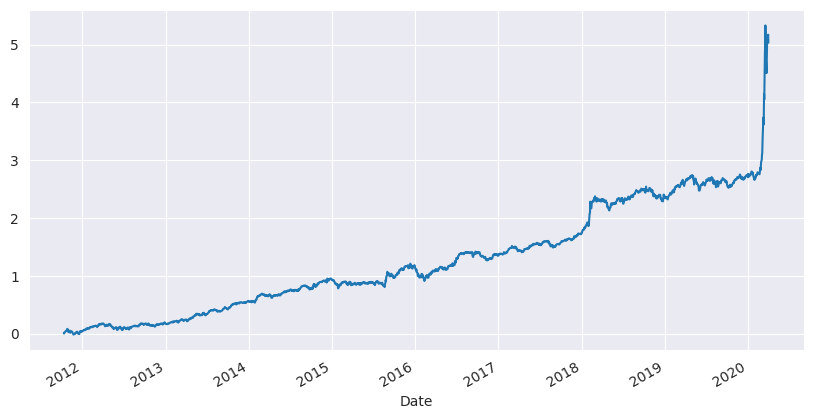

In [29]:
lslv_returns["portfolio_cumulative_returns"].plot(figsize=(10,5))